# Create Data Vector

To validate and test the y3 cluster pipeline we make a simplified mock data of the Buzzard v.1.9.8 dataset. Here I build the data vector.

Outline:
- Number counts
- Binned $\gamma_t(\theta)$ profiles
- Power Spectrum (using nbody-tool kit)


In [1]:
#!/usr/bin/env python
import os, fitsio

import sys
import numpy as np
import matplotlib.pyplot as plt
from astropy.io.fits import getdata
from astropy.table import Table

In [2]:
import matplotlib
matplotlib.rc('xtick', labelsize=20, top=True, direction='in')
matplotlib.rc('ytick', labelsize=20, right=True, direction='in')
matplotlib.rc('axes', linewidth=1, labelsize=20)
matplotlib.rc('xtick.major', size=5)
#matplotlib.rc('xtick.minor', size=5)
matplotlib.rc('ytick.major', size=5)
#matplotlib.rc('ytick.minor', size=5)

## Load Mock

For this first validation we will use $\lambda>5$.

For more information how this file was created take a look at the source code.
https://github.com/estevesjh/muStarSigmaProfiles/blob/main/notebooks/0.CreateCopacabanaCatalogs.ipynb

In [3]:
from fileLoc import FileLocs

floc = FileLocs(machine='nersc')
print('halo file name: %s'%floc.mock_fname)

halo file name: /global/cfs/cdirs/des/jesteves/data/buzzard/v1.9.8/y3_rm/mock_buzzard_like_y3_v0.fits


In [15]:
data = Table(getdata(floc.mock_fname))
print('All data size: %i'%(len(data)))

All data size: 583043


In [21]:
lgt5 = np.array(data['lambda_mor'])>=5.
lgt20 = np.array(data['lambda_mor'])>=20.

mock = data[lgt5]

print(r'$\lambda>5$ has size: %i'%np.count_nonzero(lgt5))
print(r'$\lambda>20$ has size: %i'%np.count_nonzero(lgt20))

$\lambda>5$ has size: 263387
$\lambda>20$ has size: 11210


# Number Counts

We will try to use the same bining scheme from DES Y1.

$$
\lambda \in [5, 20, 30, 45, 60, \infty] \\
z \in [0.2, 0.35, 0.5, 0.65]
$$

However in the Buzzard simulations the overall number of cluster is less than the DES Y3. So, we might need to change the binning scheme in order to have a reasonable statistics.

In [30]:
from setup_bins import lbdbins, zbins

print('lambda bins:', lbdbins)
print('redshift bins:', zbins)

lambda bins: [  5  20  30  45  60 900]
redshift bins: [0.2  0.35 0.5  0.65]


In [107]:
def compute_number_counts(x, z, xbins, zbins):
    counts = []
    for xl, xh in zip(xbins[:-1], xbins[1:]):
        xmask = (x>=xl)&(x<=xh)
        xcounts = []
        for zl, zh in zip(zbins[:-1], zbins[1:]):
            zmask = (z>=zl)&(z<=zh)
            xcounts.append(np.count_nonzero(zmask&xmask))
        counts.append(xcounts)
    return np.array(counts)

In [108]:
lbd = np.array(mock['lambda_mor'])
z = np.array(mock['redshift'])

nc_all_binY3 = compute_number_counts(lbd, z, lbdbins, zbins)

In [109]:
print(nc_all_binY3)

[[ 41451  83129 127597]
 [  1633   2777   3685]
 [   538    901   1036]
 [   121    197    163]
 [    59     60     40]]


In [110]:
lb60 = (lbd<lbdbins[-1])&(lbd>=lbdbins[-2])

(array([ 2., 13., 25., 36., 29., 23., 12., 12.,  5.,  2.]),
 array([14.553033 , 14.6221075, 14.691183 , 14.760258 , 14.829332 ,
        14.898407 , 14.967483 , 15.036557 , 15.105632 , 15.174707 ,
        15.243782 ], dtype=float32),
 <BarContainer object of 10 artists>)

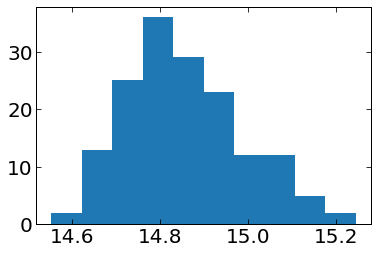

In [112]:
plt.hist(np.log10(mock['Mvir'][lb60]))

The number of clusters on the last lambda bins are very low, specially for the highest one. We should re-define the lambda bins

In [73]:
lbdbins_new = np.array([5, 15, 25, 40, 160])
print('lambda bins:', lbdbins_new)

lambda bins: [  5  15  25  40 160]


(90, 312995.3962722788)

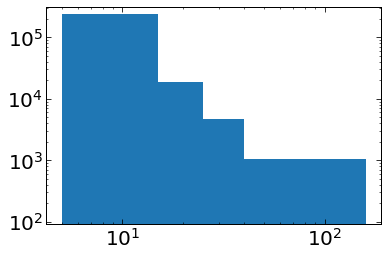

In [74]:
plt.loglog()
plt.hist(lbd, bins=lbdbins_new)
plt.ylim(90,)

In [75]:
lbd = np.array(mock['lambda_mor'])
z = np.array(mock['redshift'])

nc_all_new = compute_number_counts(lbd, z, lbdbins_new, zbins)
print(nc_all_new)

[[ 38937  78533 121239]
 [  3601   6495   8908]
 [   980   1623   2013]
 [   284    413    361]]


Now we have at least 100 clusters on the highest lambda bins

In [69]:
nc_all_new.flatten()

array([ 38038,  76906, 118981,   3706,   6760,   9326,   1340,   2240,
         2975,    718,   1158,   1239])

# $\gamma_t(\theta)$ Profiles

In this section we will convert the physical quantities of the $\Delta \Sigma (R)$ profiles in observed $\gamma_t(\theta)$ profiles. 

The conversion happens in three steps:
- The conversion factor between matter excess and the observed shear profile is  $\Sigma^{\prime}_{\rm crit} (z, r)$ 
- The second step is to convert physical units to angular units
- Lastly, we stack the profiles in lambda and redshift bins.

In [78]:
import radial_bins_phys_mpc as rbp

radii = rbp.rp_phys_mpc
deltaSigma = np.array(mock['DeltaSigma'])

In [89]:
path_boost = '/global/cfs/cdirs/des/jesteves/data/boost_factor/y1/tamas_profiles/'
fname_base = path_boost+'full-unblind-v2-mcal-zmix_y1clust_l%i_z%i_zpdf_boost_resp.dat'

In [103]:
# R, B, Sigma = np.genfromtxt(path_boost+'full-unblind-v2-mcal-zmix_y1clust_l5_z0_zpdf_boost_resp.dat',unpack=True)
R, B, Sigma = np.genfromtxt(fname_base%(0,0),unpack=True)


In [90]:
np.load(fname_base%(0,3))

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/cdirs/des/jesteves/data/boost_factor/y1/tamas_profiles/full-unblind-v2-mcal-zmix_y1clust_l0_z3_zpdf_boost_resp.dat'